In [2]:
# Add analysis to the path
import sys
import pathlib
parent_dir = os.path.join(os.path.abspath(''), "..")
sys.path.append(parent_dir)

import parsers
import matplotlib.pyplot as plt
import portion
import functools
import traceback
import math
from aggregation import *
from matplotlib import rc
from collections import namedtuple
from dataclasses import dataclass
from pprint import pprint, pformat

rc('font',**{'family': 'serif', 'size': 19})
rc('text', usetex=True)

path_to_results = os.path.normpath(os.path.join(parent_dir, "archive"))
print(path_to_results)
working_dir = os.path.normpath(os.path.join(parent_dir, "working"))
data = parsers.main(path_to_results, working_dir=working_dir)
print("Finished")

/home/jazev/dev/cs4365/analysis/archive
Extracting 30 top level archives on 4 workers
Finished


In [3]:
CpuEntry = namedtuple('CpuEntry', 'time cpu interval')
  
def extract_intervals(iterable, predicate):
    first_matched = None
    last = None
    for (idx, item) in enumerate(iterable):
        if predicate(item):
            last = idx
            if first_matched is None:
                first_matched = idx
        else:
            if first_matched is not None:
                interval = portion.closed(first_matched, idx)
                first_matched = None
                last = None
                yield interval
    if first_matched is not None and last is not None:
        yield portion.closed(first_matched, last)

def get_cpu_entries(container: parsers.Container, sampling_period=0.1) -> List[CpuEntry]:
    if container is None:
        return []

    # Normalize entries from radvisor and moby
    entries = []
    if container.radvisor:
        entries.extend(CpuEntry(time=entry.read, cpu=entry.cpu.total, interval=None) for entry in container.radvisor[0].values())
    elif container.moby:
        entries.extend(CpuEntry(time=entry.read, cpu=entry.cpu.total, interval=None) for entry in container.moby.values())
    else:
        return []

    # Calculate the CPU percentages from the times by using the CPU time/timestamp deltas
    interval_zipped_lter = zip(
        find_deltas([entry.cpu for entry in entries]),
        find_deltas([entry.time for entry in entries]),
        entries[1:])
    utilization_entries = [CpuEntry(time=entry.time / 1E6, cpu=float(c) / t, interval=t)
        for (c, t, entry) in interval_zipped_lter if (float(c) / t) > 0] 

    if sampling_period is not None:
        # Sample the CPU utilization
        times = [entry.time for entry in utilization_entries]
        cpus = [entry.cpu for entry in utilization_entries]
        intervals = [entry.interval for entry in utilization_entries]
        min_time = min(times)
        max_time = max(times)
        sampling_period_ms = sampling_period * 1E3
        sampling_intervals = pd.interval_range(
            start=min_time, end=max_time, freq=sampling_period_ms)
        cpu_df = pd.DataFrame({'cpu': cpus, 'time': times, 'interval': intervals})
        cpu_df['sampling_intervals'] = pd.cut(
            x=cpu_df['time'], bins=sampling_intervals, include_lowest=True)
        cpu_df = cpu_df.groupby('sampling_intervals').mean()
        return [CpuEntry(cpu=row["cpu"], time=row["time"], interval=row["interval"]) for idx, row in cpu_df.iterrows() if row["cpu"] > 0]
    else:
        return utilization_entries


def get_load_interval(host: parsers.TestHost, sampling_period=0.1, min_length: int=5, load_lower_bound=0.6) -> portion.Interval:
    load_interval_lists = []

    containers = host.containers()
    if not containers:
        return None

    for container in host.containers():
        sampled_entries = get_cpu_entries(container, sampling_period=sampling_period)
        
        # Perform aggregation on measurements
        def make_time_intervals(predicate):
            idle_index_intervals = list(extract_intervals(sampled_entries, predicate))
            return [portion.closed(sampled_entries[i.lower].time, sampled_entries[i.upper].time)
                for i in idle_index_intervals]
        
        load_intervals = [interval for interval in make_time_intervals(
            lambda e: e.cpu >= load_lower_bound) if interval.upper - interval.lower >= min_length - 1]
        load_interval_lists.append(load_intervals)

    # Find universal intersections of intervals
    def combine_interval_lists(a, b):
        combined_product_intervals = (i & j for i in a for j in b)
        return [interval for interval in combined_product_intervals if not interval.empty]

    load_intervals = functools.reduce(lambda a, b: combine_interval_lists(a, b),
        load_interval_lists, portion.open(-portion.inf, portion.inf))

    # Take union of all universally intersected intervals
    return functools.reduce(lambda i1, i2: i1 | i2, load_intervals, portion.empty())


In [4]:
"""
Investigate container CPU utilization distribution for a single test
"""

def get_cpu_distribution(test):
    best_lower_threshold = None
    all_cpu_reads = []
    for replica in data[test].replicas:
        for host in replica.hosts.values():
            containers = host.containers()
            if containers:
                for container in containers:
                    cpu_entries = get_cpu_entries(container, sampling_period=0.1)
                    for entry in cpu_entries:
                        all_cpu_reads.append(entry.cpu)
    cpu_df = pd.DataFrame({'cpu': all_cpu_reads})
    print(cpu_df.describe(include="all"))

In [5]:
def describe_intervals(test: parsers.Test, top=0.10) -> List[str]:
    output = []
    try:
        output.append(f"==== {test.id} ====")
        # First, describe all intervals for the test
        hosts = flatten(replica.hosts.values() for replica in test.replicas)
        all_host_intervals = [host_collection_intervals(host) for host in hosts]
        all_container_intervals = flatten(all_host_intervals)
        all_intervals = flatten(all_container_intervals)
        intervals, _ = zip(*all_intervals)
        intervals_df = pd.DataFrame({'Read deltas (ms)': intervals})
        output.append(str(intervals_df.describe(include='all')))
        output.append("")

        # Second, describe top percentage of intervals
        top_percent = []
        top_thresholds = []
        for container_list in all_container_intervals:
            container_intervals, _ = zip(*container_list)
            limit = np.quantile(container_intervals, 1 - top)
            top_thresholds.append(limit)
            top_percent.extend(i for i in container_intervals if i > limit)
        top_percent_df = pd.DataFrame({f'Top {top*100:.1f}% container read deltas (ms)': top_percent})
        output.append(str(top_percent_df.describe(include='all')))
        top_threshold_avg = np.mean(top_thresholds)
        output.append(f"top_threshold_mu: {top_threshold_avg:.8f}")
        output.append("")

        # Third, describe all intervals during load and not during load
        load_interval_values = []
        not_load_interval_values = []
        thresholds = []
        for host, host_intervals in zip(hosts, all_host_intervals):
            containers = host.containers()
            if not containers:
                continue
            
            cpu_entries = []
            for container in containers:
                cpu_entries.extend(get_cpu_entries(container, sampling_period=0.1))

            if not cpu_entries:
                output.append(f"[WARN] No CPU entries found for {host.replica_id} in test {host.id}")
                continue

            # cpu_entries = flatten([get_cpu_entries(container, sampling_period=0.1) for container in containers])
            load_threshold = 0.5 * np.percentile([entry.cpu for entry in cpu_entries], 0.75)
            load_interval = get_load_interval(host, load_lower_bound=load_threshold)
            thresholds.append(load_threshold)
            for interval, timestamp  in flatten(host_intervals):
                if timestamp in load_interval:
                    load_interval_values.append(interval)
                else:
                    not_load_interval_values.append(interval)
        # average threshold
        threshold_avg = np.mean(thresholds)
        # distributions
        during_load_df = pd.DataFrame({f'Read deltas during load (> {threshold_avg:.1f}% CPU) (ms)': load_interval_values})
        output.append(str(during_load_df.describe(include='all')))
        not_during_load_df = pd.DataFrame({f'Read deltas not during load (> {threshold_avg:.1f}% CPU) (ms)': not_load_interval_values})
        output.append(str(not_during_load_df.describe(include='all')))
        output.append(f"threshold_mu: {threshold_avg*100:.8f}")
        # total time/proportion
        total_during_load = np.sum(load_interval_values) / 1E3
        total_not_during_load = np.sum(not_load_interval_values) / 1E3
        load = total_during_load / (total_during_load + total_not_during_load)
        output.append(f"total during load: {total_during_load:.8f}; total not during load: {total_not_during_load:.8f}; load %: {load*100:.8f}")
        output.append(f"=================")
    except Exception as ex:
        output.append("~~~~~~ failed ~~~~~~")
        output.append(str(ex))
        output.append("~~~~~~ exc ~~~~~~")
        output.append(traceback.format_exc())
        output.append("~~~~~~ stack ~~~~~~")
        output.append(traceback.format_stack())
        output.append(f"=================")
    return output

def list_to_str(l):
    if isinstance(l, str):
        return l
    elif isinstance(l, list):
        return "\n".join([list_to_str(i) for i in l])
    else:
        return pprint.pformat(l)
        

In [ ]:
# warning: takes a long time, outputs all lines to all_output

tests = [
    "d-rc-50", "d-rc-100", "d-mc-50", "d-mc-100",
    "i-rc-50", "i-rc-100", "i-mc-50", "i-mc-100",
    "ii-rc-s", "ii-rc-b", "ii-mc-s", "ii-mc-b",
    "d-r-50", "d-r-100", "d-m-50", "d-m-100",
    "i-r-50", "i-r-100", "i-m-50", "i-m-100",
    "ii-r-s", "ii-r-b", "ii-m-s", "ii-m-b"]
num = len(tests)
done = 0
all_output = []
with Pool(cpu_count()) as pool:
    for output in pool.imap_unordered(describe_intervals, (data[test] for test in tests)):
        all_output.append(output)
        print(f"{done+1}/{num} done")
        done += 1


In [ ]:
# output to file
with open("interval_out.txt", "w") as file_out:
    file_out.write(list_to_str(all_output))

In [ ]:
# print to output
print(list_to_str(all_output))

In [6]:
def get_cpu_df(container: parsers.Container) -> pd.DataFrame:
    cpu_entries = get_cpu_entries(container, sampling_period=None)
    cpu, timestamp, interval = zip(*((entry.cpu, entry.time, entry.interval) for entry in cpu_entries))
    return pd.DataFrame({'cpu': cpu, 'timestamp': normalize(timestamp), 'interval': [i / 1E6 for i in interval]})

def get_container_cpu_versus_interval_df(container: parsers.Container, window=5) -> pd.DataFrame:
    cpu_df = get_cpu_df(container)
    cpu_df["cpu_mean"] = cpu_df["cpu"].rolling(window=window).mean()
    return cpu_df[cpu_df['cpu_mean'].notnull()]

def aggregate_cpu_versus_interval(replica: parsers.TestReplica, window=5):
    aggregate_df = None
    for host in replica.hosts.values():
        containers = host.containers()
        if not containers:
            continue
        else:
            container_dfs = [get_container_cpu_versus_interval_df(container, window=window) for container in containers]
            for container_df in container_dfs:
                if aggregate_df is not None:
                    aggregate_df = aggregate_df.append(container_df)
                else:
                    aggregate_df = container_df
    return aggregate_df

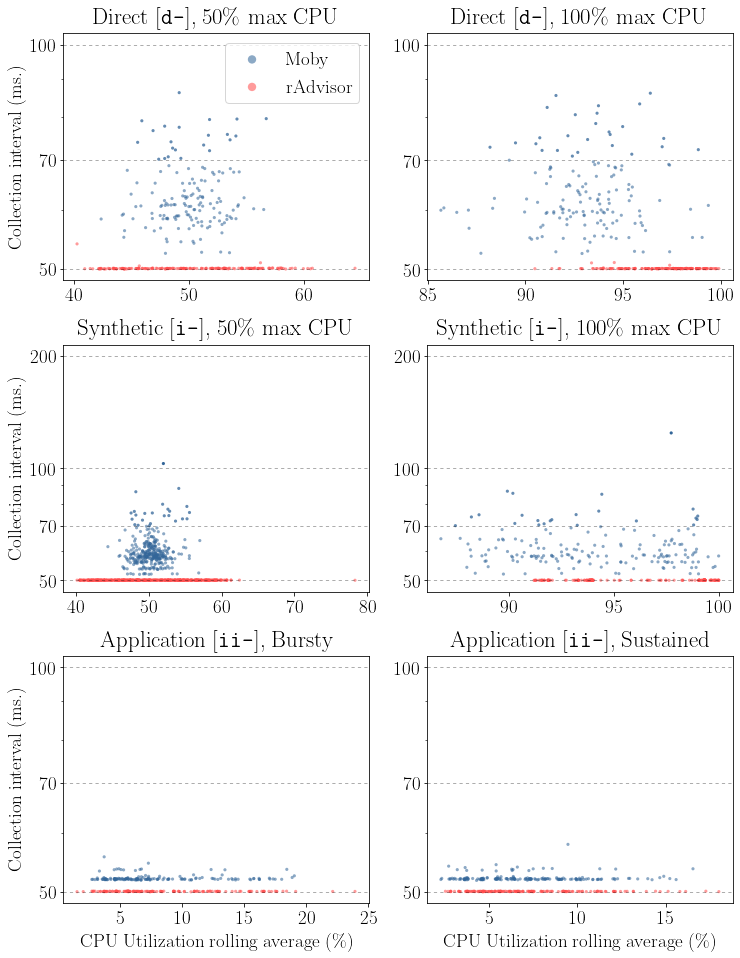

In [27]:
# x - cpu utilization over a 0.5 second rolling interval
# y - measured interval

from matplotlib import colors
import matplotlib.ticker as mticker

plt.rcParams['lines.solid_capstyle'] = 'round'
special_positions = [50, 70, 100]


def expand(x, y, gap=1e-4):
    add = np.tile([0, gap, np.nan], len(x))
    x1 = np.repeat(x, 3) + add
    y1 = np.repeat(y, 3) + add
    return x1, y1


def remap(alpha, a, b, c, d):
    return c + ((alpha - a) / (b - a)) * (d - c)


def nrange(min, max, num=20, mode='linear'):
    points = None
    if mode == 'log':
        points = list(np.logspace(math.log10(min), math.log10(max), num=num + 1, endpoint=True))
    else:
        points = list(np.linspace(min, max, num=num + 1, endpoint=True))
    if not points:
        return []
    else:
        return zip(points[0:-1], points[1:])


def np_grid_density_reduction(data, x_mode='linear', y_mode='linear', slices=10, density_factor=0.4):
    min_x = np.min(data[:,0])
    max_x = np.max(data[:,0])
    min_y = np.min(data[:,1])
    max_y = np.max(data[:,1])

    x_slice_size = (max_x - min_x) / slices
    y_slice_size = (max_y - min_y) / slices

    reduced_segments = []
    max_cell_density = (1 / float(slices ** 2)) * density_factor
    max_cell_size = int(max_cell_density * data.size)
    rng = np.random.default_rng()

    for (x1, x2) in nrange(min_x, max_x, num=slices, mode=x_mode):
        x_filtered = data[(x1 <= data[:,0]) & (data[:,0] < x2)]
        # if the entire slice is less than the cell size, no need to break it up
        if x_filtered.size // 2 > max_cell_size:
            for (y1, y2) in nrange(min_y, max_y, num=slices, mode=y_mode):
                y_filtered = x_filtered[(y1 <= x_filtered[:,1]) & (x_filtered[:,1] < y2)]
                if y_filtered.size // 2 > max_cell_size:
                    reduced_segments.append(rng.choice(y_filtered, max_cell_size, replace=False))
                else:
                    reduced_segments.append(y_filtered)
        else:
            reduced_segments.append(x_filtered)
    
    return np.concatenate(reduced_segments)


def scatter_cpu_versus_interval(ax, df, color, label=None, size=5, alpha=0.5, overlap=True, slices=10, sample=1, min_size=1, max_size=1):
    # Perform binned density reduction
    intervals = df['interval']
    cpu = [c * 100 for c in df['cpu_mean']]

    # Convert array to numpy array and perform visual grid-based reduction
    zipped_data = list((c, i) for (c, i) in zip(cpu, intervals) if i > 37.5 and 0 <= c <= 100)
    data_np_arr = np.array(zipped_data)
    data_np_arr = np.random.default_rng().choice(data_np_arr, int(sample * (data_np_arr.size // 2)), replace=False)
    cpu = [i[0] for i in data_np_arr]
    intervals = [i[1] for i in data_np_arr]
    
    min_size_interval= 50
    max_size_interval = 200
    sizes = [w * size for w in (
                min_size if i < min_size_interval else
                max_size if i > max_size_interval else
                remap(i, min_size_interval, max_size_interval, min_size, max_size)
                for i in intervals)]

    if overlap:
        alphas = [min(1, alpha * w) for w in (
                    0.75 if i < special_positions[1] else
                    1.0  if i < special_positions[2] else
                    1.35 for i in intervals)]
        dotcolors=[colors.to_rgba(color, a) for a in alphas]
        ax.scatter(cpu, intervals, s=sizes, color=dotcolors, edgecolors='none', label=label)
    else:
        ax.plot(*expand(cpu, intervals), lw=size, color=color, alpha=alpha)


def multiprocess_aggregate_cpu_versus_interval(tup):
    replica, window = tup
    return aggregate_cpu_versus_interval(replica, window=window)


def test_aggregate_cpu_versus_interval(test, window=5):
    # replicas = [data[test].replicas[0]]
    replicas = data[test].replicas
    aggregate_df = None
    with Pool(cpu_count()) as pool:
        for df in pool.imap_unordered(multiprocess_aggregate_cpu_versus_interval, zip(replicas, [window] * len(replicas))):
            if aggregate_df is None:
                aggregate_df = df
            else:
                aggregate_df.append(df)
    return aggregate_df


def plot_test_comparison(test_a, test_b, test_a_legend, test_b_legend, axes_labels, title, window=5, ax=None):
    alpha = 0.75
    size = 10
    density_factor = 1
    sample = 0.1
    slices = 50
    color_a = (0.2, 0.4, 0.6)
    color_b = (1, 0.3, 0.3)
    
    test_a_df = test_aggregate_cpu_versus_interval(test_a, window=window).sample(frac=sample, replace=False, random_state=1)
    test_b_df = test_aggregate_cpu_versus_interval(test_b, window=window).sample(frac=sample, replace=False, random_state=1)

    ax = ax or plt.gca()
    ticks = [*special_positions]
    if test_a_df['interval'].max() > 100 or test_b_df['interval'].max() > 100:
        ticks.append(200)
    if test_a_df['interval'].max() > 200 or test_b_df['interval'].max() > 200:
        ticks.append(500)
    if test_a_df['interval'].max() > 500 or test_b_df['interval'].max() > 500:
        ticks.append(1000)
    for t in ticks:
        ax.axhline(y=t, color='black', linestyle='dashed', alpha=0.4, lw=0.8, dashes=[4, 4])

    ax.set_title(title, pad=10)
    scatter_cpu_versus_interval(ax, test_a_df, color=color_a, slices=slices, size=size, sample=1, alpha=alpha, overlap=True, label=test_a_legend)
    scatter_cpu_versus_interval(ax, test_b_df, color=color_b, slices=slices, size=size, sample=1, alpha=alpha, overlap=True, label=test_b_legend)
    ax.set_yscale('log')
    if axes_labels[0]:
        ax.set_ylabel("Collection interval (ms.)")
    if axes_labels[1]:
        ax.set_xlabel("CPU Utilization rolling average (\%)")
    ax.xaxis.labelpad = 5
    if test_a_legend and test_b_legend:
        lgnd = ax.legend(loc="upper right")
        lgnd.legendHandles[0]._sizes = [70]
        lgnd.legendHandles[1]._sizes = [70]
    ax.set_yticks(ticks)
    ax.get_yaxis().set_major_formatter(mticker.ScalarFormatter())
    ax.get_yaxis().set_minor_formatter(mticker.NullFormatter())


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12,16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.19, hspace=0.26)
plot_test_comparison("d-m-50",  "d-r-50",  "Moby", "rAdvisor", (True, False),  "Direct [\\texttt{d-}], 50\\% max CPU",     ax=ax1)
plot_test_comparison("d-m-100", "d-r-100", None,   None,       (False, False), "Direct [\\texttt{d-}], 100\\% max CPU",    ax=ax2)
plot_test_comparison("i-m-50",  "i-r-50",  None,   None,       (True, False),  "Synthetic [\\texttt{i-}], 50\\% max CPU",  ax=ax3)
plot_test_comparison("i-m-100", "i-r-100", None,   None,       (False, False), "Synthetic [\\texttt{i-}], 100\\% max CPU", ax=ax4)
plot_test_comparison("ii-m-b",  "ii-r-b",  None,   None,       (True, True),   "Application [\\texttt{ii-}], Bursty",      ax=ax5)
plot_test_comparison("ii-m-s",  "ii-r-s",  None,   None,       (False, True),  "Application [\\texttt{ii-}], Sustained",   ax=ax6)
plt.savefig('cpu_interval_matrix.pdf', bbox_inches='tight')
